In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import hstack
import gc

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge, LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rc('font', family = 'NanumGothic')
mpl.rc('axes', unicode_minus = False)

In [3]:
mercari_df = pd.read_csv("mercari_train.tsv", sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


# 데이터 전처리

In [6]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

Text(0.5, 1.0, 'log 변환 전 Price 분포도')

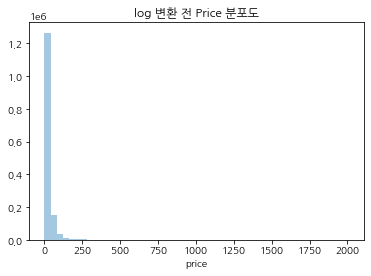

In [16]:
# price 컬럼(target)의 데이터 분포도
y_train_df = mercari_df['price']
plt.figure(figsize = (6, 4))
sns.distplot(y_train_df, kde = False)
plt.title('log 변환 전 Price 분포도')

Text(0.5, 1.0, 'log 변한 후 Price 분포도')

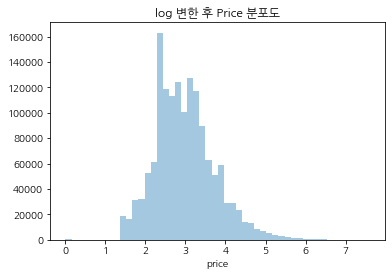

In [17]:
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde = False)
plt.title('log 변한 후 Price 분포도')

In [4]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [26]:
print('Shipping 값 유형: \n', mercari_df['shipping'].value_counts(), '\n')
print('item_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형: 
 0    819435
1    663100
Name: shipping, dtype: int64 

item_condition_id 값 유형: 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [5]:
# item_condition 칼럼은 description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있다.
boolean_cond = mercari_df['item_description'] == 'No description yet'
boolean_cond

0           True
1          False
2          False
3          False
4          False
           ...  
1482530    False
1482531    False
1482532    False
1482533    False
1482534    False
Name: item_description, Length: 1482535, dtype: bool

In [28]:
mercari_df[boolean_cond]['item_description']

0          No description yet
13         No description yet
31         No description yet
90         No description yet
117        No description yet
                  ...        
1482430    No description yet
1482447    No description yet
1482470    No description yet
1482496    No description yet
1482498    No description yet
Name: item_description, Length: 82489, dtype: object

In [6]:
mercari_df[boolean_cond]['item_description'].count()

82489

#### category_name

In [8]:
mercari_df['category_name'].head(3)

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
Name: category_name, dtype: object

In [9]:
# apply lambda 에서 호출되는 대, 중, 소 분할 함수 생성
# 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except: # try 코드가 실패했을 때 나오는 코드
        # category_name이 null일 경우 split() 함수가 에러가 error가 발생
        # error를 except catch하여 대, 중, 소 분류 모두 'Other Null' 값 부여
        return ['Other_Null', 'Other_Null', 'Other_Null']

In [10]:
# 대, 중, 소 칼럼 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
        zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

In [12]:
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 유형: \n', mercari_df['cat_jung'].unique()) # 분류 개수만 추출
print('소분류 유형: \n', mercari_df['cat_so'].nunique())


대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 유형: 
 ['Tops' 'Computers & Tablets' 'Tops & Blouses' 'Home Décor' 'Jewelry'
 'Other' 'Swimwear' 'Apparel' 'Collectibles' 'Makeup' 'Fragrance'
 'Dresses' 'Office supplies' 'Shoes' 'Gear' 'Athletic Apparel'
 'Cell Phones & Accessories' 'Jeans' 'Underwear' 'Skin Care' 'Toys'
 "Women's Handbags" 'Video Games & Consoles' 'Coats & Jackets' 'Pants'
 'Girls (4+)' 'Antique' 'Kitchen & Dining' 'Sweaters' 'Boys 0-24 Mos'
 'Girls 0-24 Mos' 'Maternity' 'Bedding' 'Exercise' 'Trading Cards'
 'Boys (4+)' 'Storage & Organization' 'Fan Shop' 'Girls 2T-5T'
 "Men's Accessories" 'Boys 2T-5T' "Women's Accessor

In [17]:
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('\n중분류 유형: \n', mercari_df['cat_jung'].value_counts()) 
print('\n소분류 유형: \n', mercari_df['cat_so'].value_counts())

대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64

중분류 유형: 
 Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_jung, Length: 114, dtype: int64

소분류 유형: 
 Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ..

In [14]:
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 유형: \n', mercari_df['cat_jung'].nunique()) # 분류 개수만 추출
print('소분류 유형: \n', mercari_df['cat_so'].nunique())


대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 유형: 
 114
소분류 유형: 
 871


In [19]:
# 결측치가 존재하는 칼럼을 채움
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

mercari_df.isnull().sum().sum()

0

In [39]:
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_dae,cat_jung,cat_so
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Other_Null,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,3.970292,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!",Women,Tops & Blouses,Blouse


# 피처 인코딩과 피처 벡터화

#### brand_name
OneHotEncoding 적용

In [20]:
print('brand name의 유형 건수: ', mercari_df['brand_name'].unique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수:  ['Other_Null' 'Razer' 'Target' ... 'Astroglide' 'Cumberland Bay'
 'Kids Only']
brand name sample 5건: 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


#### name
Count 기반으로 피처 벡터화 변환 적용

In [23]:
print('name의 종류 개수: ', mercari_df['name'].nunique())
print('name sample 10건: \n', mercari_df['name'][:10])

name의 종류 개수:  1225273
name sample 10건: 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


#### category_name, shipping, item_condition_id
OneHotEncoding

#### item_description
TF-IDF 적용

In [24]:
pd.set_option('max_colwidth', 200) # 컬럼너비 최대값 설정을 200으로 바꿈

In [25]:
# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기: ', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기:  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [27]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name) # 희소행렬 데이터 반환

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range = (1, 3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description']) # 희소행렬 데이터 반환

print('name vectorization shape: ', X_name.shape)
print('item_description vectorization shape: ', X_descp.shape)

name vectorization shape:  (1482535, 105757)
item_description vectorization shape:  (1482535, 50000)


In [29]:
# 인코딩 대상 칼럼을 모두 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [31]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape: {0}, X_item_cond_id shape: {1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape: {1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape: {0}, X_cat_so shape: {1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_item_cond_id shape: (1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape: (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape: (1482535, 871)


### 데이터 결합

In [32]:
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 인코딩과 벡터활르 수행한 데이터 세트 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


In [33]:
# 데이터세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect() # garbage collection, 수동으로 제거

114

# 릿지 회귀모델 구축 및 평가

In [34]:
# 평가 모델 RMSLE
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

In [35]:
def evaluate_org_price(y_test, preds):
    # 원본 데이터는 log1p로 변환되었으므로 expm1로 원복 필요
    preds_expm = np.expm1(preds)
    y_test_expm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_expm, preds_expm)
    return rmsle_result

In [36]:
# 학습용 데이터 생성하고, 모델 학습/예측하는 함수
def model_train_predict(model, matrix_list):
    X = hstack(matrix_list).tocsr() # 희소행렬 결합
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size = 0.2, random_state = 42)
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

In [40]:
linear_model = Ridge(solver = 'lsqr', fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('item description을 제외했을 때 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('item description을 포함한 rmsle 값: ', evaluate_org_price(y_test, linear_preds))


item description을 제외했을 때 rmsle 값:  0.5043174840721716
item description을 포함한 rmsle 값:  0.4720922104998887


**item_description을 포함했을 때, rmsle 값이 많이 감소했는 걸 보아, item_description 영향이 중요함을 알 수 있다.**

# LightGBM 회귀모델 구축과 앙상블을 이용한 최종 예측 평가

In [42]:
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# n_estimators를 1000이상 증가시키면 예측성능은 좋아지지만 수행시간이 오래 걸리므로 200으로 작게 설정
lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM rmsle 값: ', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값:  0.45790875304402046


### 앙상블 최종 예측결과

In [43]:
# 각 회귀모델의 예측결과값을 앙상블
preds = lgbm_preds * 0.45 + linear_preds * 0.55 # 비율은 임의산정
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값: ', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값:  0.4512304868618376


### 다른 비율들의 예측결과

In [88]:
ensembles = []
lgbm_preds_k = []
linear_preds_k = []

for idx, k in enumerate(np.arange(0, 1, 0.05)):
    lgbm_preds_k.append(k)
    linear_preds_k.append(1-k)
    
    preds = lgbm_preds * k + linear_preds * (1 - k)
    ensembles.append(evaluate_org_price(y_test, preds))
    print('{0:.2f}, {1:.2f} 에서의 rmsle값: {2}'.format(k, 1-k, ensembles[idx]))

0.00, 1.00 에서의 rmsle값: 0.4720922104998887
0.05, 0.95 에서의 rmsle값: 0.4686725373046303
0.10, 0.90 에서의 rmsle값: 0.46551697908368217
0.15, 0.85 에서의 rmsle값: 0.46263094037211133
0.20, 0.80 에서의 rmsle값: 0.4600194938768515
0.25, 0.75 에서의 rmsle값: 0.45768733988017857
0.30, 0.70 에서의 rmsle값: 0.4556387670174876
0.35, 0.65 에서의 rmsle값: 0.45387761512834573
0.40, 0.60 에서의 rmsle값: 0.4524072408822695
0.45, 0.55 에서의 rmsle값: 0.4512304868618376
0.50, 0.50 에서의 rmsle값: 0.4503496547430473
0.55, 0.45 에서의 rmsle값: 0.4497664831482477
0.60, 0.40 에서의 rmsle값: 0.44948213065998754
0.65, 0.35 에서의 rmsle값: 0.449497164378698
0.70, 0.30 에서의 rmsle값: 0.4498115542858854
0.75, 0.25 에서의 rmsle값: 0.45042467354311727
0.80, 0.20 에서의 rmsle값: 0.4513353047198074
0.85, 0.15 에서의 rmsle값: 0.4525416518060522
0.90, 0.10 에서의 rmsle값: 0.4540413577361909
0.95, 0.05 에서의 rmsle값: 0.45583152702863794


In [90]:
df = pd.DataFrame({'lgbm_preds_k': lgbm_preds_k, 
                    'linear_preds_k': linear_preds_k,
                    'ensembles': ensembles})
df

,lgbm_preds_k,linear_preds_k,ensembles
0,0.00,1.00,0.472092
1,0.05,0.95,0.468673
2,0.10,0.90,0.465517
3,0.15,0.85,0.462631
4,0.20,0.80,0.460019
5,0.25,0.75,0.457687
6,0.30,0.70,0.455639
7,0.35,0.65,0.453878
8,0.40,0.60,0.452407
9,0.45,0.55,0.451230


In [94]:
df.sort_values(by = 'ensembles')

,lgbm_preds_k,linear_preds_k,ensembles
12,0.60,0.40,0.449482
13,0.65,0.35,0.449497
11,0.55,0.45,0.449766
14,0.70,0.30,0.449812
10,0.50,0.50,0.450350
15,0.75,0.25,0.450425
9,0.45,0.55,0.451230
16,0.80,0.20,0.451335
8,0.40,0.60,0.452407
17,0.85,0.15,0.452542


In [95]:
# 최종결과
preds = lgbm_preds * 0.6 + linear_preds * 0.4
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값: ', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값:  0.44948213065998754
